# Compare aligned spike and template shapes

author: steeve.laquitaine@epfl.ch

Method:  

0. engineering spike instance dataset with '/gpfs/bbp.cscs.ch/data/project/proj68/home/laquitai/spike-sorting/notebooks/2_deepnet/0b_dataeng_neuropix_32.ipynb'
1. choose a channel
2. find nearby ground truth cells (within 40 microns of the channel)
3. reduce dimensionality of spikes and universal templates
4. plot univ. templates, missed sparse cells, detected sparse cells on the reduced space

note: we flip the templates and explained variance is normalized by the squared norm of the spike snippet ||D||**2.

## Setup

Virtual env is `env_kilosort_silico`

You should have extracted the templates from a KS3 run by running `python3.9 -m src.pipes.postpro.univ_temp` in the terminal before. See usage in `univ_temp` module.


In [1]:
# SETUP PACKAGES 
%load_ext autoreload
%autoreload 2
import os 
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns

# SET PROJECT PATH
PROJ_PATH = "/gpfs/bbp.cscs.ch/project/proj68/home/laquitai/spike-sorting"
os.chdir(PROJ_PATH)


# SETUP PROJECT PACKAGE
from src.nodes.utils import get_config
from src.nodes.truth.silico import ground_truth
from src.pipes.postpro import univ_temp
from src.nodes.postpro import reduction
from src.nodes.postpro import template_matching as temp_match

# SET DATA PATH 
# whole campaign files
SPIKE_FILE_PATH = '/gpfs/bbp.cscs.ch/project/proj68/scratch/laquitai/dataeng/0_silico/neuropixels_lfp_10m_2023_02_19/f3c730ef-8dd9-4d6d-8c18-3ddb7d3eeee7/campaign/raw/spiketrains.pkl'
RAW_LFP_TRACE_FILE_PATH = '/gpfs/bbp.cscs.ch/project/proj68/scratch/laquitai/dataeng/0_silico/neuropixels_lfp_10m_2023_02_19/f3c730ef-8dd9-4d6d-8c18-3ddb7d3eeee7/campaign/raw/traces.pkl'
CELL_TRACE_FILE_PATH = '/gpfs/bbp.cscs.ch/project/proj68/scratch/laquitai/dataeng/0_silico/neuropixels_lfp_10m_2023_02_19/f3c730ef-8dd9-4d6d-8c18-3ddb7d3eeee7/campaign/raw/cells/cell_3754013_trace.pkl'


# SET PARAMETERS
EXPERIMENT = "silico_neuropixels"
SIMULATION_DATE = "2023_02_19"
STUDY_FOLDER = '/gpfs/bbp.cscs.ch/project/proj68/scratch/laquitai/sorting/0_silico/neuropixels_lfp_10m_2023_02_19/f3c730ef-8dd9-4d6d-8c18-3ddb7d3eeee7/campaign/study'
SAMPLING_FREQ = 10000 # sample/sec
EXAMPLE_CELL_ID = 4209594
EXAMPLE_CHANNEL_ID = 20
MS_BEFORE = 9  # duration of snippet portion extracted from recording before true timestamp (ms)
MS_AFTER = 9   # duration of snippet portion extracted from recording after true timestamp (ms)
SNIPPET_DURATION = 6 # duration of snippet to project (ms)
CELL_TYPE = "PYR"
LOAD_WAVEFORM_EXTRACTOR = False
LOAD_GROUND_TRUTH = True
LOAD_PREP_TRACE = True


# SET CHANNEL AND NEAREST CELLS
NEAREST_CHANNEL = 30
MISSED_CELL_IDS = [165135, 288502, 273515, 288502, 342702, 37423, 39862, 424433]
DETECTED_CELL_IDS = [19690, 367098]  


# SET CONFIG
data_conf, param_conf = get_config(EXPERIMENT, SIMULATION_DATE).values()


# SET MODEL INPUT DATA PATHS
INSTANCE_FILE_PATH = data_conf["postprocessing"]["shape_study"]["instances"]
CHANNEL_IDS_FILE_PATH = data_conf["postprocessing"]["shape_study"]["channel_ids"]
CELL_LABELS_FILE_PATH = data_conf["postprocessing"]["shape_study"]["cell_labels"]
SPIKE_STATUS_FILE_PATH = data_conf["postprocessing"]["shape_study"]["spike_status"]
NEAREST_CHANNEL_FILE_PATH  = data_conf["postprocessing"]["shape_study"]["nearest_channel"]


# SET PLOT PARAMETERS
N_TOTAL_COLORS = 30
N_DETECTED_COLORS = 15
colors = np.array(sns.color_palette('tab10', n_colors=N_TOTAL_COLORS))
detected_colors = colors[:N_DETECTED_COLORS,]
missed_colors = colors[N_DETECTED_COLORS:,]

2023-05-15 09:39:29,316 - root - utils.py - get_config - INFO - Reading experiment config.
2023-05-15 09:39:29,356 - root - utils.py - get_config - INFO - Reading experiment config. - done
2023-05-15 09:39:29,634 - root - utils.py - get_config - INFO - Reading experiment config.
2023-05-15 09:39:29,658 - root - utils.py - get_config - INFO - Reading experiment config. - done


## Load spike data

0. spike instance dataset was engineered with '/gpfs/bbp.cscs.ch/data/project/proj68/home/laquitai/spike-sorting/notebooks/2_deepnet/0b_dataeng_neuropix_32.ipynb'

In [2]:
# load spike data
all_instances = pd.read_pickle(INSTANCE_FILE_PATH)
channel_ids = pd.read_pickle(CHANNEL_IDS_FILE_PATH)
cells = pd.read_pickle(CELL_LABELS_FILE_PATH)
spike_status = pd.read_pickle(SPIKE_STATUS_FILE_PATH)
nearest_channel = pd.read_pickle(NEAREST_CHANNEL_FILE_PATH)

## Check templates, the spikes of missed and detected cell

spike count: 66
2023-05-15 09:39:41,963 - root - ground_truth.py - load - INFO - loading already processed ground truth SortingExtractor ...
2023-05-15 09:39:42,016 - root - ground_truth.py - load - INFO - loading already processed true sorting - done in 0.1
spike count: 5
2023-05-15 09:39:42,091 - root - ground_truth.py - load - INFO - loading already processed ground truth SortingExtractor ...
2023-05-15 09:39:42,102 - root - ground_truth.py - load - INFO - loading already processed true sorting - done in 0.0


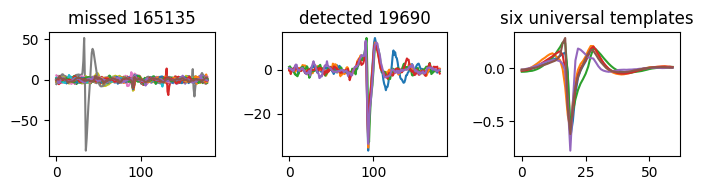

In [3]:
# set parameters
NEAREST_CHANNEL = 30
MISSED_CELL = 165135
DETECTED_CELL = 19690

# setup plots
fig, axes = plt.subplots(1,3, figsize=(7,2))

# plot a missed sparse cell
missed_cell_instances = all_instances.iloc[np.where((cells.values==MISSED_CELL) & (channel_ids.values==NEAREST_CHANNEL) & (spike_status.values==True))[0].tolist()]
axes[0].plot(missed_cell_instances.T);
axes[0].set_title(f"missed {MISSED_CELL}");
print("spike count:", missed_cell_instances.shape[0])
Truth = ground_truth.load(data_conf)
assert Truth.get_total_num_spikes()[MISSED_CELL] == missed_cell_instances.shape[0], "spike count does not make sense"

# plot a detected sparse cell
detected_cell_instances = all_instances.iloc[np.where((cells.values==DETECTED_CELL) & (channel_ids.values==NEAREST_CHANNEL) & (spike_status.values==True))[0].tolist()]
axes[1].plot(detected_cell_instances.T);
axes[1].set_title(f"detected {DETECTED_CELL}");

print("spike count:", detected_cell_instances.shape[0])
Truth = ground_truth.load(data_conf)
assert Truth.get_total_num_spikes()[DETECTED_CELL] == detected_cell_instances.shape[0], "spike count does not make sense"

# plot Kilosort3's six universal templates
univ_templates = univ_temp.load(data_conf)
univ_templates = univ_templates.T[:,:-1]
univ_templates = univ_templates
axes[2].plot(univ_templates.T);
axes[2].set_title("six universal templates");

plt.tight_layout()

## Template-match spikes

Template alignment can position template far from ground truth spike timestamp, more so when spike snippet period is long, and other spikes occur within the period. To make sure that we capture the ground truth spike's signal and not noise or another spike, we selected the max explained variance of the template fit to the signal within a narrow window centered on the ground truth spike timestamp.

TODO:
- constrain the maximization of explained variance in a more restricted neighborhood (about the duration of a cell's refractory period, g., -/+1 ms) centered on the ground truth spike's timestamp to avoid extracting other spike signals, that would be better fitted than our target spike signal.

## Plot best-fitted instances of template 1 and best-matched signals (detected spikes) in 2D

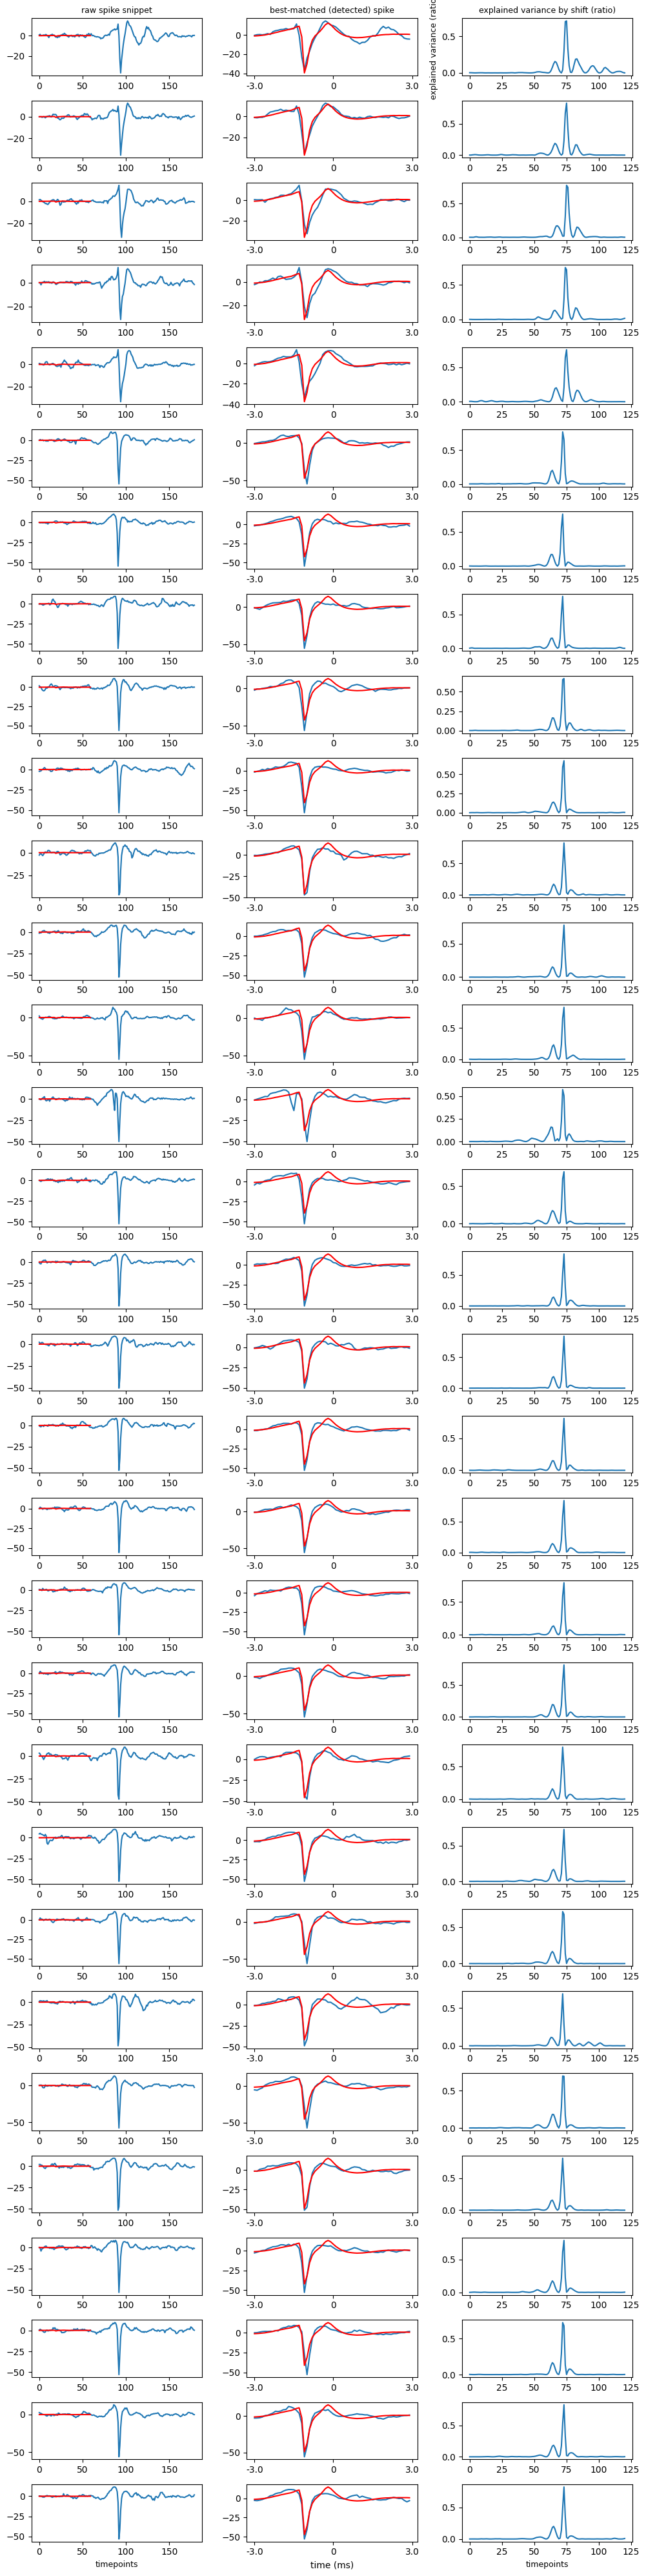

In [4]:
# get all detected spikes (instances x timepoints)
detected_loc = np.where((cells.values==DETECTED_CELL_IDS) & (channel_ids.values==NEAREST_CHANNEL) & (spike_status.values==True))[0].tolist()
detected_instances = all_instances.iloc[detected_loc,:]

# apply template matching (convolution)
extracted_detected_spikes, best_fit_temps_to_detected_spikes, max_explained_var_for_detected, best_fit_shifts, fig = temp_match.template_match(
    detected_instances,
    univ_templates[0],
    neighborhood=(6,9), 
    timepoints_before=30,
    timepoints_after=30,
    sampling_freq=10000,
    figsize=(10,40)).values()

# calculate spike snippet duration we want to dim-reduce in (ms)
spike_snippet_duration = SNIPPET_DURATION * SAMPLING_FREQ / 1000

# sanity checks
# check that spike snippets and template have the correct duration
assert extracted_detected_spikes.shape[1] == best_fit_temps_to_detected_spikes.shape[1] == spike_snippet_duration

# check shift is in correct neighborhood
neighbh_start_tpoints = int(6*SAMPLING_FREQ/1000)
neighbh_end_tpoints =  int(9*SAMPLING_FREQ/1000)
assert all((np.array(best_fit_shifts)>=neighbh_start_tpoints) & (np.array(best_fit_shifts)<=neighbh_end_tpoints)), "a best fit shift is not within the restricted neighborhood of the true timestamp as enforced"

# check explained variance within [0,1]
assert all((max_explained_var_for_detected >=0) & (max_explained_var_for_detected <=1))


TODO:  
- position raw template at its aligned position in column 1 of the figure to see where it best fits the signal.
- parametrize template_match with ms instead of timepoints

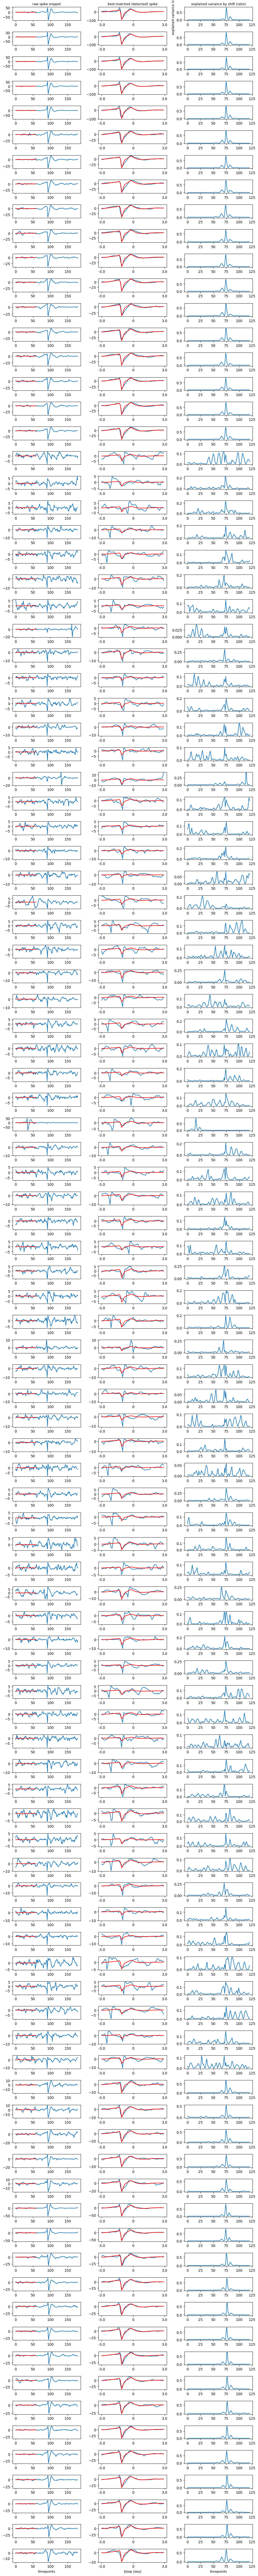

In [5]:
# get all missed spikes (instances x timepoints)
missed_sparse_loc = np.where((cells.values==MISSED_CELL_IDS) & (channel_ids.values==NEAREST_CHANNEL) & (spike_status.values==True))[0].tolist()
missed_sparse_instances = all_instances.iloc[missed_sparse_loc,:]

# apply template matching
extracted_missed_spikes, best_fit_temps_to_missed_spikes, max_explained_var_for_missed, best_fit_shifts, fig = temp_match.template_match(
    missed_sparse_instances,
    univ_templates[0],
    neighborhood=(6,9), 
    timepoints_before=30,
    timepoints_after=30,
    sampling_freq=10000,
    figsize=(10,100)).values()

# sanity checks
# check correct duration
assert extracted_missed_spikes.shape[1] == best_fit_temps_to_missed_spikes.shape[1] == spike_snippet_duration, "spike snippets and template do not have the correct duration"

# check shift is in correct neighborhood
neighbh_start_tpoints = int(6*SAMPLING_FREQ/1000)
neighbh_end_tpoints =  int(9*SAMPLING_FREQ/1000)
assert all((np.array(best_fit_shifts)>=neighbh_start_tpoints) & (np.array(best_fit_shifts)<=neighbh_end_tpoints)), "a best fit shift is not within the restricted neighborhood of the true timestamp as enforced"

# check explained variance within [0,1]
assert all((max_explained_var_for_missed >=0) & (max_explained_var_for_missed <=1))

## Fit templates to spikes via projection

In [6]:
def get_cell_labels(cells, channel_ids, spike_status, missed_ids, detected_ids, nearest_channel):
    
    # get missed cell labels
    loc = np.where((cells.values==missed_ids) & (channel_ids.values==nearest_channel) & (spike_status.values==True))[0].tolist()
    missed_cells = cells.values[loc]

    # get detected cell labels
    loc = np.where((cells.values==detected_ids) & (channel_ids.values==nearest_channel) & (spike_status.values==True))[0].tolist()
    detected_cells = cells.values[loc]
    return detected_cells, missed_cells

## Plot fitted template and its matched signal (detected spike)

note: scaling a template translates its coordinates along a line (red crosses) in the reduced 2D pca space. This makes sense.

In [7]:
# format instances to dim-reduce
instances = np.vstack([extracted_detected_spikes, extracted_missed_spikes])
template_fits = np.vstack([best_fit_temps_to_detected_spikes, best_fit_temps_to_missed_spikes])

# get all labels
# get cell labels
detected_cells, missed_cells = get_cell_labels(cells, channel_ids, spike_status, MISSED_CELL_IDS, DETECTED_CELL_IDS, NEAREST_CHANNEL)
template_label = np.vstack([detected_cells, missed_cells])
raw_cell_labels = np.vstack([detected_cells, missed_cells, template_label])
cell_labels = np.unique(raw_cell_labels, axis=0, return_inverse=True)[1]


# get detection labels
detection_labels = np.sum(raw_cell_labels == DETECTED_CELL_IDS, axis=1)

# get explained variance
explained_var = np.hstack([max_explained_var_for_detected, max_explained_var_for_missed]) 

# sanity check
assert instances.shape[0]*2==cell_labels.shape[0]==detection_labels.shape[0], "instances, cell_labels and detection_labels shape differ"

Hypothesis:

- The more component 2 (likely spike's first positive peak) contributes to spike shape (is pronounced) and the more likely it is that the spike will be missed (see cells 2, 1 and 5 in order).
- Component 1 is likely the spike's negative peak.


TODO:
- where is the detected cell 7 on the pca plot?
- in the current code, a cell is detected if at least one of its spike is detected and all its spikes are legended with a filled color. Further, distinguish for each cell, the detected spikes from the missed ones -> Just fill the dot if detected, leave it empty if not detected, make sure all cell have different colors.
- fix explained variance plot. Dots should have same positions as in pca and tsne plots
- component1 seem to increases with an increase in the spike negative peak amplitude. Should spikes be unit-normed to capture only changes related with shape and not SNR-related.
- component2 actually explains only 6% of variance which is 12 X less than component 1. The plot should communicate that info.
- plot component1 and 2 to see what they look like.
- test CEBRA, which does not lose information contrary to PCA. tsne distances are not meaningful to measure shape difference.

In [8]:
# setup plot
fig, axes = plt.subplots(1,2, figsize=(7,3))

# apply dim. reductions
pca_embedding, pca_model = reduction.pca_spikes_and_template_fits(axis=axes[0], spike_instances=instances, template_fits=template_fits, labels=cell_labels, detection_status=detection_labels, detected_colors=detected_colors, missed_colors=missed_colors)
tsne_embedding, tsne_model = reduction.tsne_spikes_and_template_fits(axis=axes[1], spike_instances=instances, template_fits=template_fits, labels=cell_labels, detection_status=detection_labels, detected_colors=detected_colors, missed_colors=missed_colors)

# legend
axes[0].set_title(f"pca (channel {NEAREST_CHANNEL})")
axes[1].set_title(f"t-sne (channel {NEAREST_CHANNEL})")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False);
plt.tight_layout()

# scatter plot with colored dots
fig, axes = plt.subplots(1,2, figsize=(7,3))
mappable = axes[0].scatter(pca_embedding[:len(instances),0], pca_embedding[:len(instances),1], c=explained_var, cmap="viridis")
mappable = axes[1].scatter(tsne_embedding[:len(instances),0], tsne_embedding[:len(instances),1], c=explained_var, cmap="viridis")

# legend
axes[0].set_title(f"best fit explained variance")
axes[0].set_xlabel("component1")
axes[0].set_ylabel("component2")
axes[1].set_title(f"best fit explained variance")
axes[1].set_xlabel("component1")

plt.colorbar(mappable, label="explained variance")
plt.tight_layout()

2023-05-15 09:41:23,171 - matplotlib.legend - legend.py - _parse_legend_args - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [16]:
print("pca's explained variance by component:", pca_model.explained_variance_ratio_)
print("total explained variance:", sum(pca_model.explained_variance_ratio_))

pca's explained variance by component: [0.8166208 0.0645485]
total explained variance: 0.8811693266034126


## Check mapping between detected spikes and their fitted templates

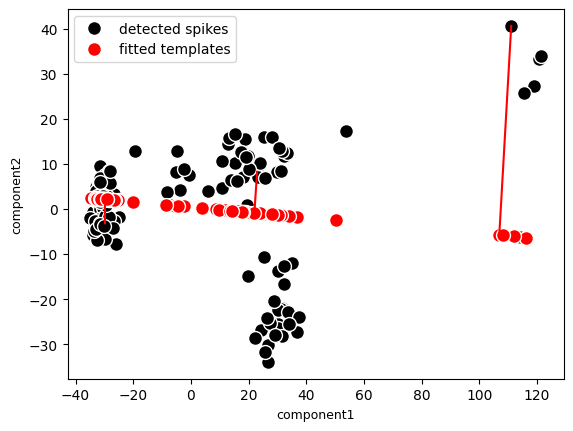

In [17]:
# map three examples of detected spikes and their fitted template
fig, ax = plt.subplots(1,1)
label=3
label_loc = cell_labels == label
x = pca_embedding[:len(instances),0]
y = pca_embedding[:len(instances),1]

# plot detected spike
ax.plot(
    x,
    y,
    marker="o",
    color="k",
    linestyle="none",
    label="detected spikes",
    markeredgecolor="w",
    markersize=10
)

# plot fitted template
ax.plot(
    pca_embedding[len(instances):,0],
    pca_embedding[len(instances):,1],
    marker="o",
    color="r",
    linestyle="none",
    label="fitted templates",
    markeredgecolor="w",
    markersize=10
)

# link the detected spike with its fitted template with a red line
# spike instance 0
plt.plot(
    [pca_embedding[:len(instances),0][0], pca_embedding[len(instances):,0][0]],
    [pca_embedding[:len(instances),1][0], pca_embedding[len(instances):,1][0]]
    , "r", linestyle="-")

# spike instance 31
plt.plot(
    [pca_embedding[:len(instances),0][31], pca_embedding[len(instances):,0][31]],
    [pca_embedding[:len(instances),1][31], pca_embedding[len(instances):,1][31]]
    , "r", linestyle="-")

# spike instance 100
plt.plot(
    [pca_embedding[:len(instances),0][100], pca_embedding[len(instances):,0][100]],
    [pca_embedding[:len(instances),1][100], pca_embedding[len(instances):,1][100]]
    , "r", linestyle="-")

# legend
ax.set_xlabel("component1", fontsize=9);
ax.set_ylabel("component2", fontsize=9);
plt.legend();

## Check fit by cell and detection status

TODO:   
- plot pca first and second components to see what they look like

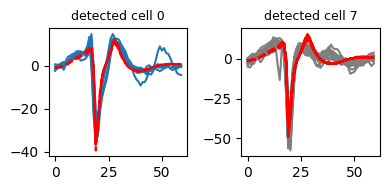

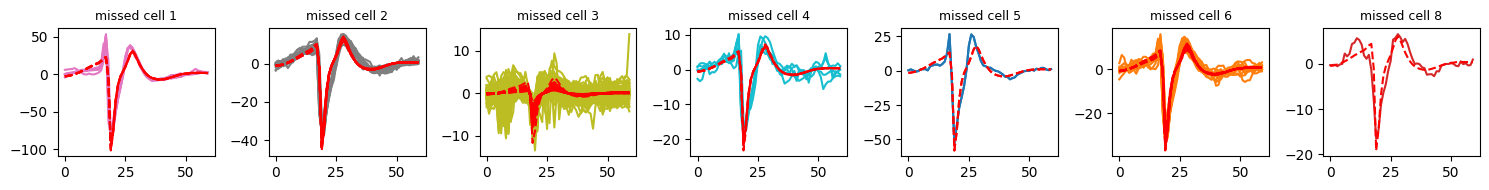

In [18]:
# plot detected cell spikes
detected_labels = np.unique(cell_labels[np.where(detection_labels==1)[0]])
fig, axes = plt.subplots(1,len(detected_labels), figsize=(4,2))
spike_cell_labels = cell_labels[:len(instances)]
template_cell_labels = cell_labels[len(instances):]
for ix, label_i in enumerate(detected_labels):
    axes[ix].plot(instances[spike_cell_labels==label_i].T, color=detected_colors[label_i,:]);
    axes[ix].plot(template_fits[template_cell_labels==label_i].T, "--r");
    axes[ix].set_title(f"detected cell {label_i}", fontsize=9)
plt.tight_layout()

# plot missed cell spikes
missed_labels = np.unique(cell_labels[np.where(detection_labels==0)[0]])
fig, axes = plt.subplots(1,len(missed_labels), figsize=(15,2))
for ix, label_i in enumerate(missed_labels):
    axes[ix].plot(instances[spike_cell_labels==label_i].T, color=missed_colors[label_i,:]);
    axes[ix].plot(template_fits[template_cell_labels==label_i].T, "--r");
    axes[ix].set_title(f"missed cell {label_i}", fontsize=9)
plt.tight_layout()

# References

[A refresher on convolution and crosscorrelation](https://www.youtube.com/watch?v=C3EEy8adxvc)